In [1]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=774e1d918f85543c0ec693995d14d8c8b92eb9a813a9a9b95d1b86b54f7e62e0
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [2]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import torch
import sys
import torchvision

In [3]:
path_to_dataset = "drive//MyDrive//M202A//nyu_depth_v2_labeled.mat"

def extract_files(config):
  path = config["path"]
  f = h5py.File(path_to_dataset)
  length = len(f["images"])
  indices = np.random.randint(0,length,size=length//3)
  batch_size = length//3
  color = np.zeros((batch_size,480,640,3))
  rawdepth = np.zeros((batch_size,480,640))
  truedepth = np.zeros_like(rawdepth)
  for i in tqdm(range(0,len(indices))):
    j = indices[i]
    # read 0-th image. original format is [3 x 640 x 480], uint8
    img = f['images'][j].astype(np.uint8)
    img = img.transpose(2,1,0)
    color[i,...] = img
    rawD = f['rawDepths'][j]
    rawdepth[i,...] = rawD.T.astype(np.float32)
    depth_from_disk = f["depths"][j].astype(np.float32)
    truedepth[i,...] = depth_from_disk.T
  config["color"] = color
  config["depth"] = truedepth
  config["rawDepth"] = rawdepth
config={"path":path_to_dataset}
extract_files(config)

100%|██████████| 483/483 [00:58<00:00,  8.25it/s]


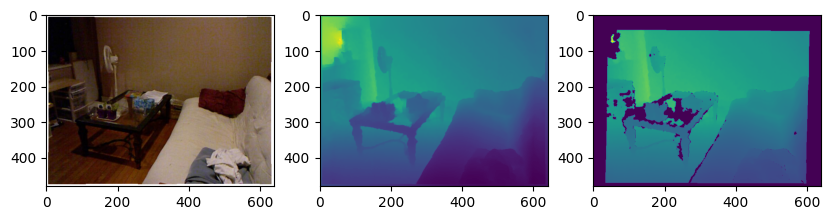

In [4]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0].astype(np.uint8))

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])

Clone Github Repo

In [5]:
!git clone https://github.com/VCL3D/DeepDepthDenoising

Cloning into 'DeepDepthDenoising'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 394 (delta 22), reused 46 (delta 22), pack-reused 345
Receiving objects: 100% (394/394), 6.33 MiB | 30.88 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [6]:
sys.path.insert(1, 'DeepDepthDenoising/')

In [7]:
import models
import utils
import importers
from supervision import *
from exporters import *
from importers import *

/content/DeepDepthDenoising/supervision/normals.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy is "upright":


In [8]:
dddpath = "drive/MyDrive/M202A/ddd"

In [9]:
model_params = {
        'width': 640,
        'height': 480,
        'ndf': 8,
        'dilation': 1,
        'norm_type': "elu",
        'upsample_type': "nearest"
    }

model = models.get_model(model_params).to("cuda")
utils.init.initialize_weights(model,dddpath)
uv_grid_t =  create_image_domain_grid(model_params['width'], model_params['height'])

In [10]:
rawdepth.shape

(483, 480, 640)

In [41]:
length = len(color)
error = []
denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
    rawD = torch.tensor(rawdepth[i],dtype=torch.float).to("cuda")

    rawD = rawD.reshape(1,1,480,640)
    mask,_ = get_mask(rawD)
    predicted_depth,_ = model(rawD,mask)
    masked_predicted_depth = predicted_depth*mask


    gt = depth[i]
    gt_tensor = torch.tensor(gt,dtype=torch.float).to("cuda")
    loss = (masked_predicted_depth-gt_tensor*mask).to("cpu").detach().numpy()
    denoised_depth_images[i,...] = predicted_depth.to("cpu").detach().numpy()
    error.append(loss)

100%|██████████| 483/483 [00:08<00:00, 59.09it/s]


Average mean squared error is  8.58773197978735
Average root mean squared error is  30.153976753354073


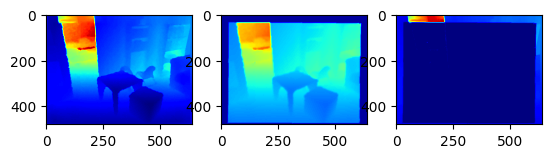

In [43]:
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average mean squared error is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3)
axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')
plt.show()